## House Prices: Advanced Regression Techniques 

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In [77]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import xgboost as xgb
import scipy.stats as stats
from scipy import stats
from scipy.stats import pointbiserialr, spearmanr, skew, pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn import linear_model

# Set matplotlib to display plots inline
%matplotlib inline

# Set seaborn style to whitegrid
sns.set_style('whitegrid')

## Data Exploration

In [78]:
# Read the training data from a CSV file
data = pd.read_csv('../root/input/train.csv')

# Read the test data from a CSV file
test = pd.read_csv('../root/input/test.csv')

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [81]:
data.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


In [11]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Wrangling

In [82]:
# Display information about columns with missing values in the DataFrame 'data'
data[data.columns[data.isnull().sum() > 0].tolist()].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   Alley         91 non-null     object 
 2   MasVnrType    1452 non-null   object 
 3   MasVnrArea    1452 non-null   float64
 4   BsmtQual      1423 non-null   object 
 5   BsmtCond      1423 non-null   object 
 6   BsmtExposure  1422 non-null   object 
 7   BsmtFinType1  1423 non-null   object 
 8   BsmtFinType2  1422 non-null   object 
 9   Electrical    1459 non-null   object 
 10  FireplaceQu   770 non-null    object 
 11  GarageType    1379 non-null   object 
 12  GarageYrBlt   1379 non-null   float64
 13  GarageFinish  1379 non-null   object 
 14  GarageQual    1379 non-null   object 
 15  GarageCond    1379 non-null   object 
 16  PoolQC        7 non-null      object 
 17  Fence         281 non-null    object 
 18  MiscFeature   54 non-null   

In [83]:
# Get the list of columns in 'data' with missing values
list_data = data.columns[data.isnull().sum() > 0].tolist()

# Get the list of columns in 'test' with missing values
list_test = test.columns[test.isnull().sum() > 0].tolist()

# Display information about columns in 'test' that are not in 'data' and have missing values
test[list(i for i in list_test if i not in list_data)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSZoning      1455 non-null   object 
 1   Utilities     1457 non-null   object 
 2   Exterior1st   1458 non-null   object 
 3   Exterior2nd   1458 non-null   object 
 4   BsmtFinSF1    1458 non-null   float64
 5   BsmtFinSF2    1458 non-null   float64
 6   BsmtUnfSF     1458 non-null   float64
 7   TotalBsmtSF   1458 non-null   float64
 8   BsmtFullBath  1457 non-null   float64
 9   BsmtHalfBath  1457 non-null   float64
 10  KitchenQual   1458 non-null   object 
 11  Functional    1457 non-null   object 
 12  GarageCars    1458 non-null   float64
 13  GarageArea    1458 non-null   float64
 14  SaleType      1458 non-null   object 
dtypes: float64(8), object(7)
memory usage: 171.1+ KB


In [84]:
# Display information about columns in 'data' that are not in 'test' and have missing values
data[list(i for i in list_data if i not in list_test)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Electrical  1459 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


In [85]:
# Create a list of column to fill NA with "None" or 0.

to_null = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath',
           'PoolQC', 'Fence', 'MiscFeature']
for col in to_null:
    if data[col].dtype == 'object':

        data[col].fillna('None',inplace=True)
        test[col].fillna('None',inplace=True)
    else:

        data[col].fillna(0,inplace=True)
        test[col].fillna(0,inplace=True)

In [86]:
# Fill NA with common values.

test.loc[test.KitchenQual.isnull(), 'KitchenQual'] = 'TA'
test.loc[test.MSZoning.isnull(), 'MSZoning'] = 'RL'
test.loc[test.Utilities.isnull(), 'Utilities'] = 'AllPub'
test.loc[test.Exterior1st.isnull(), 'Exterior1st'] = 'VinylSd'
test.loc[test.Exterior2nd.isnull(), 'Exterior2nd'] = 'VinylSd'
test.loc[test.Functional.isnull(), 'Functional'] = 'Typ'
test.loc[test.SaleType.isnull(), 'SaleType'] = 'WD'
data.loc[data['Electrical'].isnull(), 'Electrical'] = 'SBrkr'
data.loc[data['LotFrontage'].isnull(), 'LotFrontage'] = data['LotFrontage'].mean()
test.loc[test['LotFrontage'].isnull(), 'LotFrontage'] = test['LotFrontage'].mean()

In [87]:
data.loc[data.MasVnrType == 'None', 'MasVnrArea'] = 0
test.loc[test.MasVnrType == 'None', 'MasVnrArea'] = 0
test.loc[test.BsmtFinType1=='None', 'BsmtFinSF1'] = 0
test.loc[test.BsmtFinType2=='None', 'BsmtFinSF2'] = 0
test.loc[test.BsmtQual=='None', 'BsmtUnfSF'] = 0
test.loc[test.BsmtQual=='None', 'TotalBsmtSF'] = 0

In [88]:
test.loc[test.GarageCars.isnull() == True]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1116,2577,70,RM,50.0,9060,Pave,None,Reg,Lvl,AllPub,...,0,0,None,MnPrv,None,0,3,2007,WD,Alloca


In [89]:
test.loc[test.GarageCars.isnull(), 'GarageCars'] = 0
test.loc[test.GarageArea.isnull(), 'GarageArea'] = 0

## Data Visualization

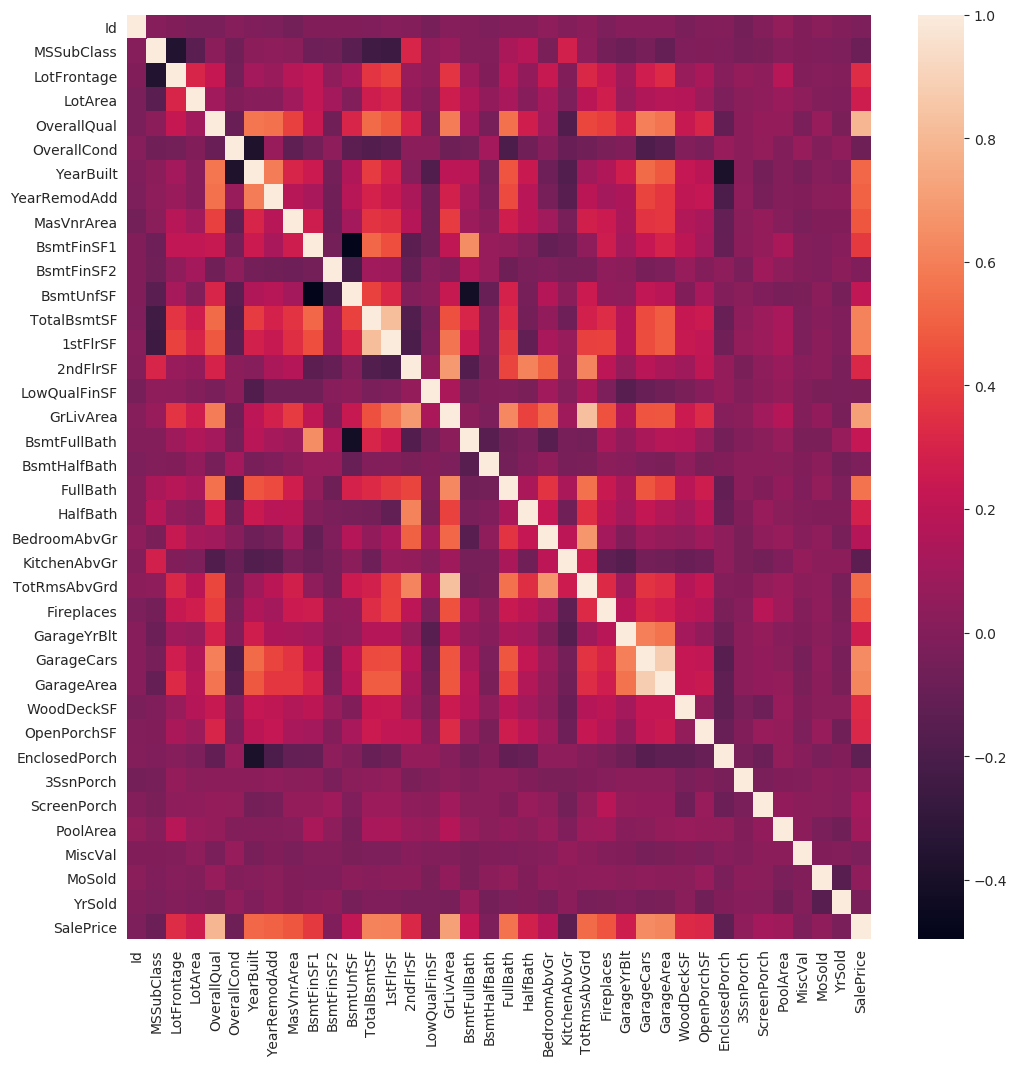

In [90]:
corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1)

In [91]:
threshold = 0.8 

def correlation():
    # Calculate correlation between columns in 'data'
    for i in data.columns:
        for j in data.columns[list(data.columns).index(i) + 1:]:
            if data[i].dtype != 'object' and data[j].dtype != 'object':
                # Calculate Pearson correlation coefficient for numerical columns
                if abs(pearsonr(data[i], data[j])[0]) >= threshold:
                    yield (pearsonr(data[i], data[j])[0], i, j)
            else:
                # Calculate Spearman correlation coefficient for categorical columns
                if abs(spearmanr(data[i], data[j])[0]) >= threshold:
                    yield (spearmanr(data[i], data[j])[0], i, j)

In [92]:
corr_list = list(correlation())
corr_list

[(0.858487256763469, 'Exterior1st', 'Exterior2nd'),
 (-0.8960687885891644, 'BsmtFinType2', 'BsmtFinSF2'),
 (0.819529975005033, 'TotalBsmtSF', '1stFlrSF'),
 (0.8254893743088428, 'GrLivArea', 'TotRmsAbvGrd'),
 (0.8824754142814623, 'GarageCars', 'GarageArea'),
 (-0.9999911109711233, 'PoolArea', 'PoolQC'),
 (0.9028952966055307, 'MiscFeature', 'MiscVal')]

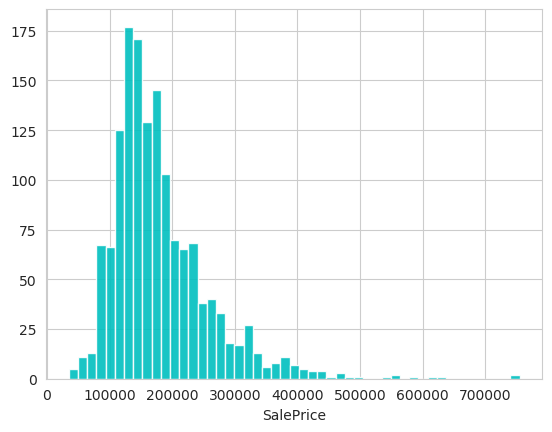

In [93]:
# Plot a histogram of 'SalePrice' column in 'data'
sns.distplot(data['SalePrice'], kde=False, color='c', hist_kws={'alpha': 0.9})

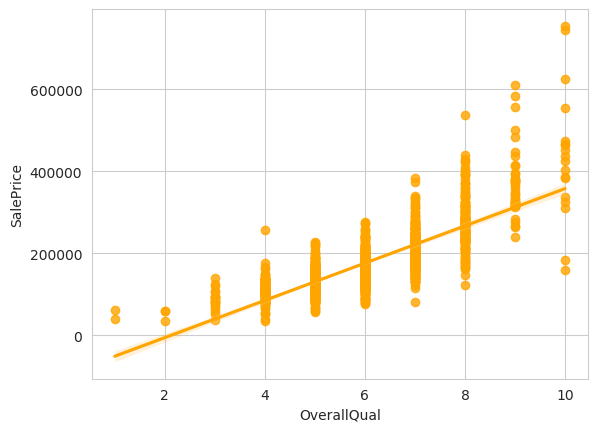

In [94]:
# Plot a regression plot between 'OverallQual' and 'SalePrice' columns in 'data'
sns.regplot(x='OverallQual', y='SalePrice', data=data, color='Orange')

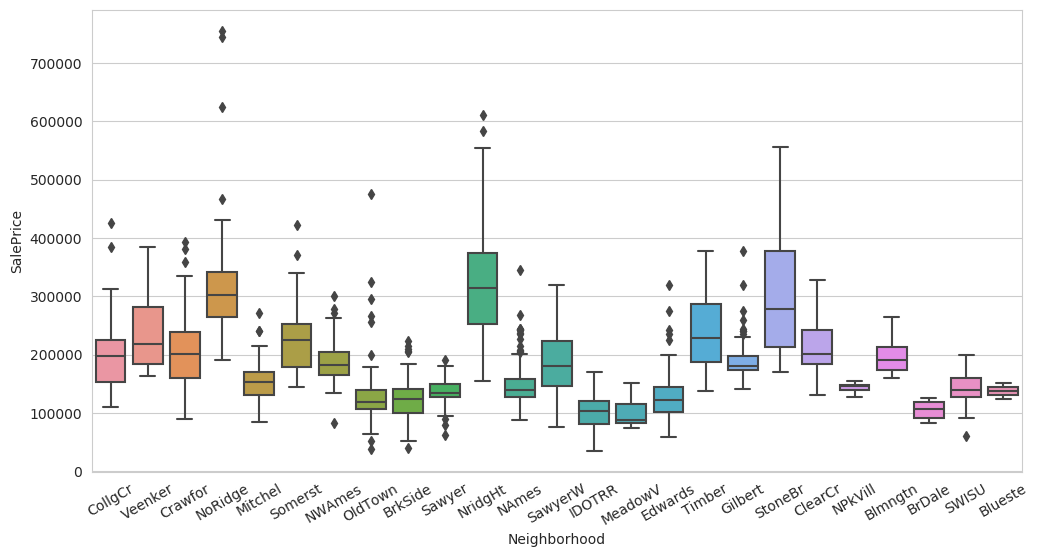

In [95]:
# Set the figure size for the box plot
plt.figure(figsize=(12, 6))

# Create a box plot of 'SalePrice' for each 'Neighborhood' in 'data'
sns.boxplot(x='Neighborhood', y='SalePrice', data=data)

# Rotate x-axis labels for better readability
xt = plt.xticks(rotation=30)

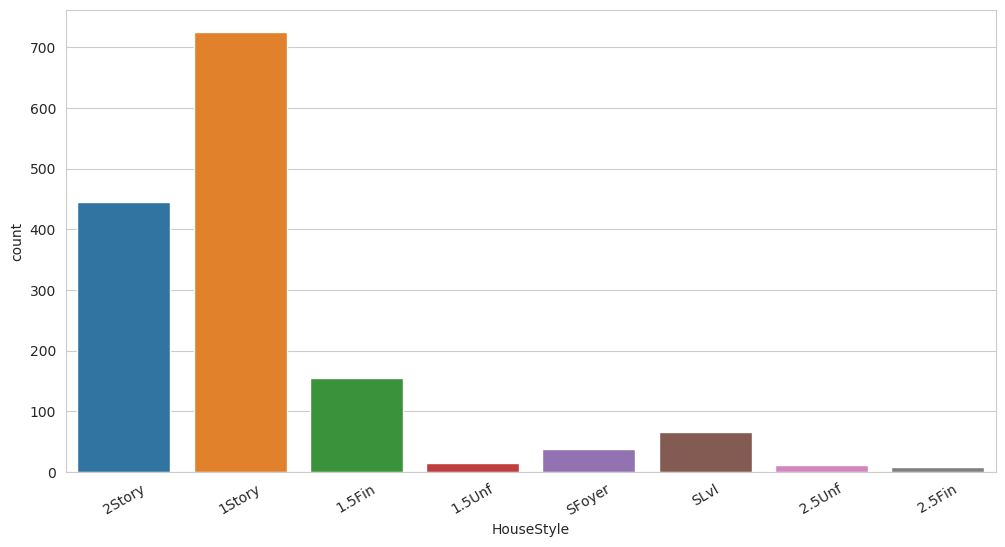

In [96]:
# Set the figure size for the count plot
plt.figure(figsize=(12, 6))

# Create a count plot of 'HouseStyle' in 'data'
sns.countplot(x='HouseStyle', data=data)

# Rotate x-axis labels for better readability
xt = plt.xticks(rotation=30)

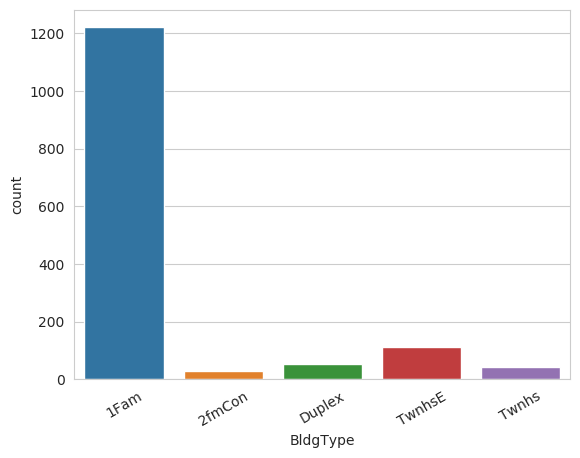

In [97]:
# Create a count plot of 'BldgType' in 'data'
sns.countplot(x='BldgType', data=data)

# Rotate x-axis labels for better readability
xt = plt.xticks(rotation=30)

In [98]:
# Create a cross-tabulation of 'Fireplaces' and 'FireplaceQu' in 'data'
pd.crosstab(data.Fireplaces, data.FireplaceQu)

FireplaceQu,Ex,Fa,Gd,None,Po,TA
Fireplaces,,,,,,
0,0,0,0,690,0,0
1,19,28,324,0,20,259
2,4,4,54,0,0,53
3,1,1,2,0,0,1


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


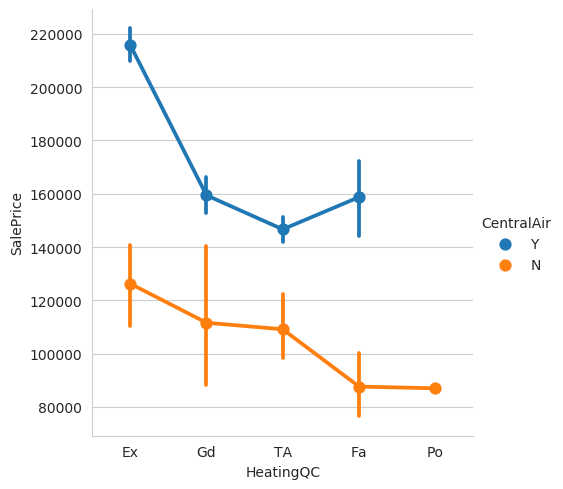

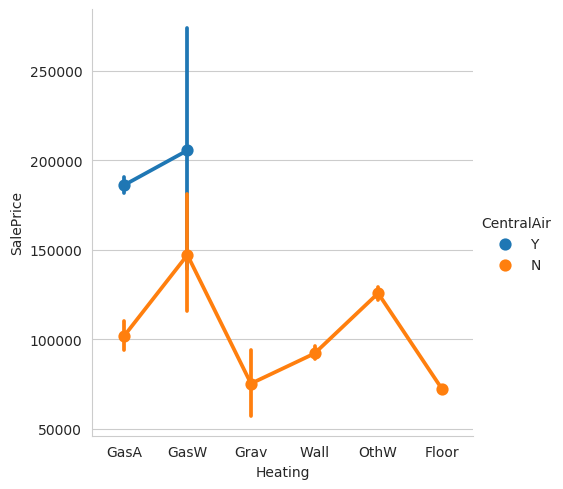

In [99]:
# Create a factor plot to analyze the relationship between 'HeatingQC', 'SalePrice', and 'CentralAir'
sns.factorplot('HeatingQC', 'SalePrice', hue='CentralAir', data=data)

# Create a factor plot to analyze the relationship between 'Heating', 'SalePrice', and 'CentralAir'
sns.factorplot('Heating', 'SalePrice', hue='CentralAir', data=data)

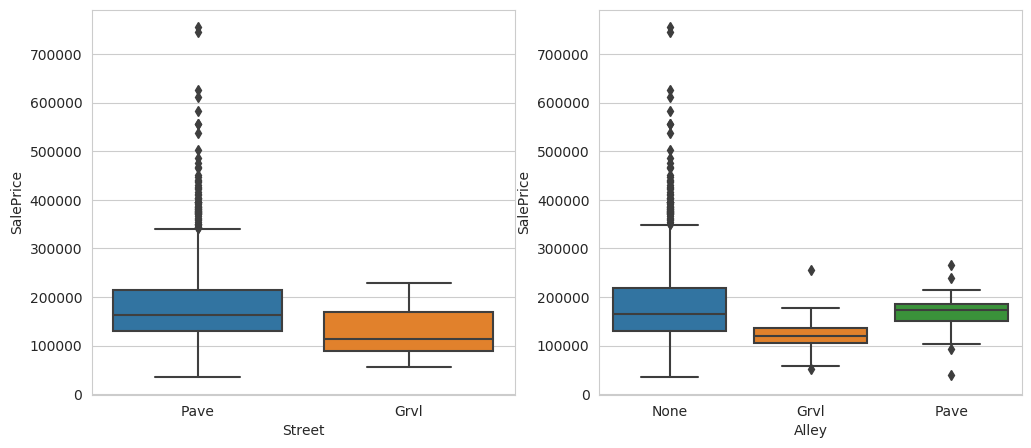

In [100]:
# Create subplots with 1 row and 2 columns, and set the figure size
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Create a box plot of 'SalePrice' for each 'Street' category in 'data' and assign it to the first subplot
sns.boxplot(x='Street', y='SalePrice', data=data, ax=ax[0])

# Create a box plot of 'SalePrice' for each 'Alley' category in 'data' and assign it to the second subplot
sns.boxplot(x='Alley', y='SalePrice', data=data, ax=ax[1])

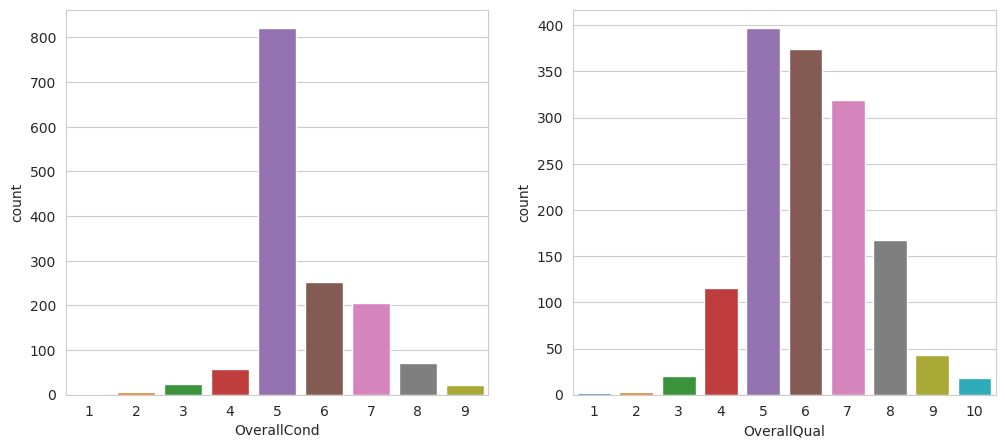

In [101]:
# Create subplots with 1 row and 2 columns, and set the figure size
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Create a count plot of 'OverallCond' in 'data' and assign it to the first subplot
sns.countplot(x='OverallCond', data=data, ax=ax[0])

# Create a count plot of 'OverallQual' in 'data' and assign it to the second subplot
sns.countplot(x='OverallQual', data=data, ax=ax[1])

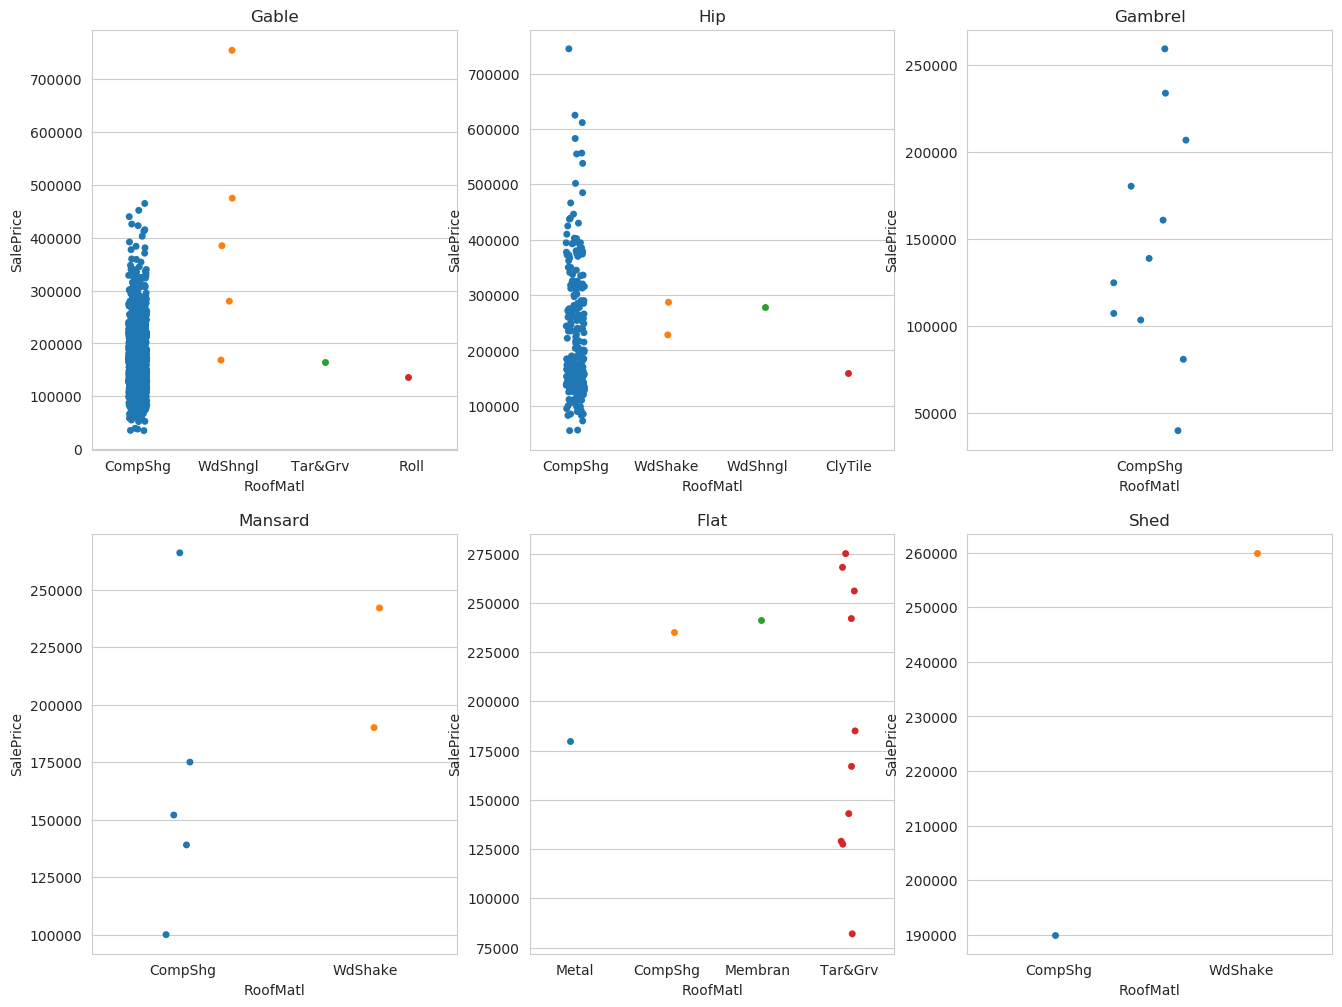

In [102]:
# Create subplots with 2 rows and 3 columns, and set the figure size
fig, ax = plt.subplots(2, 3, figsize=(16, 12))

# Set titles for each subplot
ax[0, 0].set_title('Gable')
ax[0, 1].set_title('Hip')
ax[0, 2].set_title('Gambrel')
ax[1, 0].set_title('Mansard')
ax[1, 1].set_title('Flat')
ax[1, 2].set_title('Shed')

# Create strip plots for each RoofStyle category using the corresponding RoofMatl data
sns.stripplot(x="RoofMatl", y="SalePrice", data=data[data.RoofStyle == 'Gable'], jitter=True, ax=ax[0, 0])
sns.stripplot(x="RoofMatl", y="SalePrice", data=data[data.RoofStyle == 'Hip'], jitter=True, ax=ax[0, 1])
sns.stripplot(x="RoofMatl", y="SalePrice", data=data[data.RoofStyle == 'Gambrel'], jitter=True, ax=ax[0, 2])
sns.stripplot(x="RoofMatl", y="SalePrice", data=data[data.RoofStyle == 'Mansard'], jitter=True, ax=ax[1, 0])
sns.stripplot(x="RoofMatl", y="SalePrice", data=data[data.RoofStyle == 'Flat'], jitter=True, ax=ax[1, 1])
sns.stripplot(x="RoofMatl", y="SalePrice", data=data[data.RoofStyle == 'Shed'], jitter=True, ax=ax[1, 2])

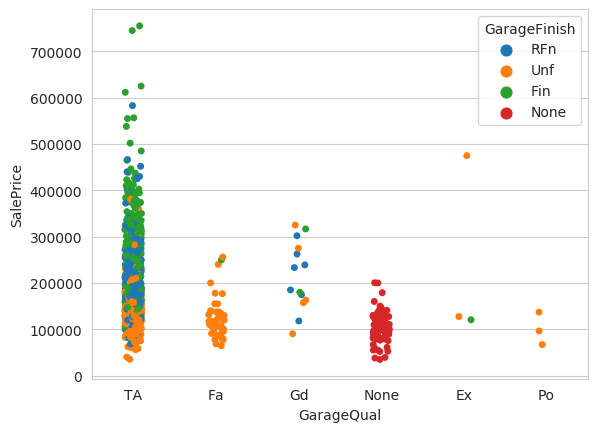

In [103]:
# Create a strip plot to analyze the relationship between 'GarageQual', 'SalePrice', and 'GarageFinish'
sns.stripplot(x="GarageQual", y="SalePrice", data=data, hue='GarageFinish', jitter=True)

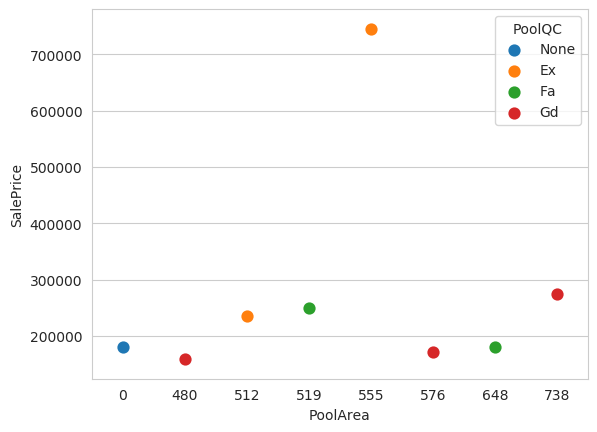

In [104]:
# Create a point plot to analyze the relationship between 'PoolArea', 'SalePrice', and 'PoolQC'
sns.pointplot(x="PoolArea", y="SalePrice", hue="PoolQC", data=data)

In [40]:
data.loc[data.PoolArea == 555]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,...,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000


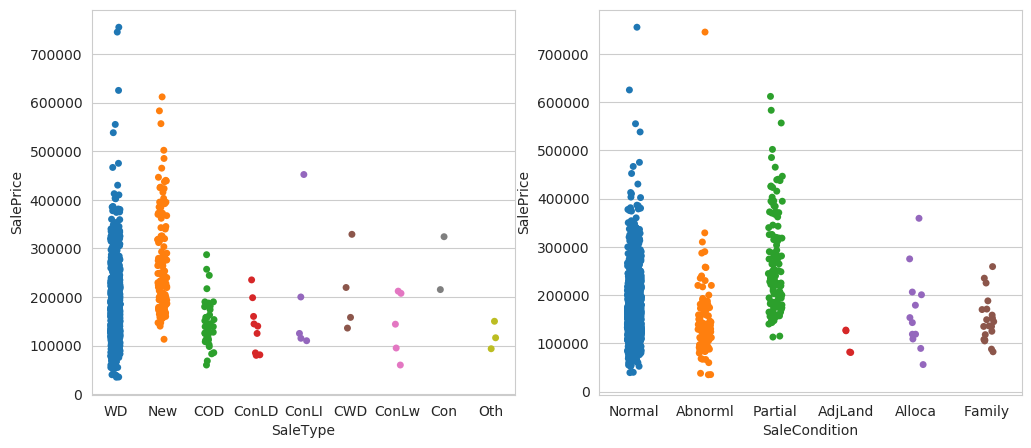

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
sns.stripplot(x="SaleType", y="SalePrice", data=data, jitter=True, ax=ax[0])
sns.stripplot(x="SaleCondition", y="SalePrice", data=data, jitter=True, ax=ax[1])

## Data Preparation

In [42]:
data['MSSubClass'].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40])

In [43]:
data['MSSubClass'] = data['MSSubClass'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

In [105]:
# Log-transform skewed numerical columns in 'data'
for col in data.columns:
    if data[col].dtype != 'object':
        if skew(data[col]) > 0.75:
            data[col] = np.log1p(data[col])

        # For numerical columns with low skewness, no transformation is applied
        
    else:
        # Convert categorical columns into dummy variables in 'data'
        dummies = pd.get_dummies(data[col], drop_first=False)
        dummies = dummies.add_prefix("{}_".format(col))
        
        # Drop original categorical column from 'data'
        data.drop(col, axis=1, inplace=True)
        
        # Join the dummy variables to 'data'
        data = data.join(dummies)

# Log-transform skewed numerical columns in 'test'
for col in test.columns:
    if test[col].dtype != 'object':
        if skew(test[col]) > 0.75:
            test[col] = np.log1p(test[col])
        
        # For numerical columns with low skewness, no transformation is applied
        
    else:
        # Convert categorical columns into dummy variables in 'test'
        dummies = pd.get_dummies(test[col], drop_first=False)
        dummies = dummies.add_prefix("{}_".format(col))
        
        # Drop original categorical column from 'test'
        test.drop(col, axis=1, inplace=True)
        
        # Join the dummy variables to 'test'
        test = test.join(dummies)

In [106]:
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,...,0,0,0,1,0,0,0,0,1,0
1,2,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,...,0,0,0,1,0,0,0,0,1,0
2,3,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,...,0,0,0,1,0,0,0,0,1,0
3,4,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,...,0,0,0,1,1,0,0,0,0,0
4,5,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,...,0,0,0,1,0,0,0,0,1,0


In [107]:
X_train = data.drop('SalePrice',axis=1)
Y_train = data['SalePrice']
X_test  = test

## Modelling

In [115]:
def rmlse(val, target):
    """
    Calculate the root mean squared logarithmic error (RMSLE) between predicted 'val' and actual 'target' values.

    Parameters:
    val (array-like): Predicted values.
    target (array-like): Actual values.

    Returns:
    float: Root mean squared logarithmic error (RMSLE) value.
    """
    return np.sqrt(np.sum(((np.log1p(val) - np.log1p(np.expm1(target)))**2) / len(target)))

In [116]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, Y_train, test_size=0.33)

In [117]:
# Ridge

ridge = Ridge(alpha=10, solver='auto').fit(Xtrain, ytrain)
val_ridge = np.expm1(ridge.predict(Xtest))
rmlse(val_ridge, ytest)

0.14112074022472745

In [118]:
# RidgeCV

ridge_cv = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
ridge_cv.fit(Xtrain, ytrain)
val_ridge_cv = np.expm1(ridge_cv.predict(Xtest))
rmlse(val_ridge_cv, ytest)

0.14273031396873231

In [119]:
# Lasso

las = linear_model.Lasso(alpha=0.0005).fit(Xtrain, ytrain)
las_ridge = np.expm1(las.predict(Xtest))
rmlse(las_ridge, ytest)

0.13896353952335583

In [120]:
# LassoCV

las_cv = LassoCV(alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
las_cv.fit(Xtrain, ytrain)
val_las_cv = np.expm1(las_cv.predict(Xtest))
rmlse(val_las_cv, ytest)

0.13896353952335583

In [121]:
# XGBoost

model_xgb = xgb.XGBRegressor(n_estimators=340, max_depth=2, learning_rate=0.2) #the params were tuned using xgb.cv
model_xgb.fit(Xtrain, ytrain)
xgb_preds = np.expm1(model_xgb.predict(Xtest))
rmlse(xgb_preds, ytest)

0.13752201672866657

In [122]:
# Random Forest

forest = RandomForestRegressor(min_samples_split =5,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = None,
                                max_depth = None,
                                n_estimators = 300,
                                max_features = 'auto')

forest.fit(Xtrain, ytrain)
Y_pred_RF = np.expm1(forest.predict(Xtest))
rmlse(Y_pred_RF, ytest)

0.1423999125013776

In [123]:
# Create a pandas Series of coefficients with corresponding column names
coef = pd.Series(las_cv.coef_, index=X_train.columns)

# Count the number of non-zero coefficients
v = coef.loc[las_cv.coef_ != 0].count()

In [124]:
# Get the indices of the top 'v' absolute coefficient values in descending order
indices = np.argsort(abs(las_cv.coef_))[::-1][0:v]

In [125]:
# Get the column names of the top 'v' features based on their indices
features = X_train.columns[indices]

# Check if any of the top features are missing in the test set
for i in features:
    if i not in X_test.columns:
        print(i)

In [126]:
X_test['RoofMatl_ClyTile'] = 0

In [133]:
# Select the subset of features in X_train based on the top 'v' indices
X = X_train[features]

# Select the corresponding subset of features in X_test
Xt = X_test[features]

In [134]:
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X, Y_train, test_size=0.33)

In [135]:
ridge = Ridge(alpha=5, solver='svd').fit(Xtrain1, ytrain1)
val_ridge = np.expm1(ridge.predict(Xtest1))
rmlse(val_ridge, ytest1)

0.12018989147455619

In [136]:
las_cv = LassoCV(alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10)).fit(Xtrain1, ytrain1)
val_las = np.expm1(las_cv.predict(Xtest1))
rmlse(val_las, ytest1)

0.12129959320471131

In [138]:
model_xgb = xgb.XGBRegressor(n_estimators=340, max_depth=2, learning_rate=0.2)
model_xgb.fit(Xtrain1, ytrain1)
xgb_preds = np.expm1(model_xgb.predict(Xtest1))
rmlse(xgb_preds, ytest1)

0.12628524862754786

In [139]:
forest = RandomForestRegressor(min_samples_split =5,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = None,
                                max_depth = 100,
                                n_estimators = 300,
                                max_features = None)

forest.fit(Xtrain1, ytrain1)
Y_pred_RF = np.expm1(forest.predict(Xtest1))
rmlse(Y_pred_RF, ytest1)

0.14602170589233945

In [140]:
las_cv1 = LassoCV(alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
las_cv1.fit(X, Y_train)
lasso_preds = np.expm1(las_cv1.predict(Xt))

In [141]:
model_xgb = xgb.XGBRegressor(n_estimators=340, max_depth=2, learning_rate=0.1)
model_xgb.fit(X, Y_train)
xgb_preds = np.expm1(model_xgb.predict(Xt))

In [142]:
preds = 0.7 * lasso_preds + 0.3 * xgb_preds

In [143]:
# Create a LassoCV model with specified alpha values
model_lasso = LassoCV(alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 100))

# Fit the LassoCV model to the training data
model_lasso.fit(X_train, Y_train)

# Create a pandas Series of coefficients with corresponding column names
coef = pd.Series(model_lasso.coef_, index=X_train.columns)

# Count the number of non-zero coefficients
v1 = coef.loc[model_lasso.coef_ != 0].count()

In [144]:
# Get the indices of the top 'v1' absolute coefficient values in descending order
indices = np.argsort(abs(model_lasso.coef_))[::-1][0:v1]

# Get the column names of the top features based on their indices
features_f = X_train.columns[indices]

In [145]:
print('Features in full, but not in val:')
for i in features_f:
    if i not in features:
        print(i)
print('\n' + 'Features in val, but not in full:')
for i in features:
    if i not in features_f:
        print(i)

Features in full, but not in val:
RoofMatl_ClyTile
Functional_Maj2
Heating_GasW
BldgType_1Fam
Fence_GdWo
Alley_Pave
KitchenAbvGr
ExterQual_TA
Condition1_Artery
SaleCondition_Family
Heating_Grav
Exterior1st_VinylSd
BsmtFinType2_BLQ
Exterior1st_HdBoard
YrSold
RoofStyle_Gable
LotShape_IR2

Features in val, but not in full:
Exterior1st_AsbShng
GarageType_CarPort
Exterior2nd_Wd Sdng
GarageQual_Gd
Alley_Grvl
Functional_Mod
MasVnrType_Stone
LandSlope_Sev
ExterQual_Ex
Exterior2nd_Plywood
LotFrontage
BsmtFinType1_BLQ
SaleType_ConLD
ExterCond_Gd
FireplaceQu_Ex
Neighborhood_Timber
CentralAir_Y


In [146]:
for i in features_f:
    if i not in X_test.columns:
        X_test[i] = 0
        print(i)
X = X_train[features_f]
Xt = X_test[features_f]

In [147]:
model_lasso = LassoCV(alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
model_lasso.fit(X, Y_train)
lasso_preds = np.expm1(model_lasso.predict(Xt))

In [148]:
model_xgb = xgb.XGBRegressor(n_estimators=340, max_depth=2, learning_rate=0.1)
model_xgb.fit(X, Y_train)
xgb_preds = np.expm1(model_xgb.predict(Xt))

In [150]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":0.7*lasso_preds + 0.3*xgb_preds})
solution.to_csv("house_price.csv", index = False)